## Modules

In [504]:
from qutip import *
from qutip import mesolve, Options, expect
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

## Fonctions

Dans une experience, pour effectuer une impulsion $\pi/2$ le champ est initialement nul (avec l'atome dans l'état fondamental). Une impulsion du champ est alors imposée pour une durée déterminée afin de préparer l'atome dans l'état |e>. Dans ce cas, nous prendrons l'example d'une impulsion rectangle parfaite.

La fonction suivante définit le Hamiltonien dépendant du temps:

In [505]:
def hamiltonian_t(t, args):
    """ Fonction permettant de calculer le Hamiltonien à chaque temps t. """
    H0 = args['H0']
    H1 = args['H1']
    time_list = args['time_list']
    field_list = args['field_list']
    
    idx_time = np.argmin(np.abs(time_list-t))

    return H0 + field_list[idx_time] * H1


Pour toutes les applications concrètes d'une impulsion, le système n'est pas un système à deux niveaux. Pour bien contrôler les impulsions $\pi$/2 il est nécessaire de tenir compte des autres niveaux. Nous allons faire l'hypothèse qu'un troisième niveau |f> existe avec un énergie $\hbar \omega_{ef} = 1.05$. Ici nous avons noté $\omega_{ge}$ ($\hbar \omega_{ge}=1$) la fréquence de la transition $|g> \rightarrow |e>$ et $\omega_{ef}$ la fréquence de la transition $|e> \rightarrow |f>$. Les opérateurs deviennent alors:

In [506]:
etat3_g = basis(3,0)  # |g>
etat3_e = basis(3,1)  # |e>
etat3_f = basis(3,2)  # |e>

gg3 = etat3_g*etat3_g.dag()  # |g><g|
ee3 = etat3_e*etat3_e.dag()  # |e><e|
ge3 = etat3_g*etat3_e.dag()  # |g><e|
eg3 = etat3_e*etat3_g.dag()  # |e><g|
ff3 = etat3_f*etat3_f.dag()  # |f><f|
ef3 = etat3_e*etat3_f.dag()  # |e><f|
fe3 = etat3_f*etat3_e.dag()  # |f><e|
gf3 = etat3_g*etat3_f.dag()  # |g><f|
fg3 = etat3_f*etat3_g.dag()  # |f><g|

Dans ce cas, le champ est couplé aux transition $|g> \rightarrow |e>$ et $|e> \rightarrow |f>$. Bien souvent la transition $|g> \rightarrow |f>$ n'est pas permise pour des raisons de symétries.

In [507]:
anharmonicite = -1*100e6*2*np.pi # difference en fréquence entre les transitions |g> -> |e> et |e> -> |f>

delta = 0.0

pulse_width = 50e-9  # impulsion pi/2 en seconde
drive = complex(1/(4*pulse_width),0.0) * 2 * np.pi
print(drive)


H0 = delta * ee3 + (delta+anharmonicite) * ff3  #nous avons ici ajouté le troisième niveau |f>
print(H0)
# drive Hamiltonian:
H1 = (drive/2 * eg3 + np.conjugate(drive)/2 * ge3) + (drive/2 * gf3 + np.conjugate(drive)/2 * fg3)

max_time = 80e-9 # evolution temporelle entre 0 et max_time (en secondes)
time = np.linspace(0,max_time,1001)

# option pour s'assurer que mesolve n'ignore pas le changement de champ:
mesolve_max_step = 1e-9 # 5 ns

(31415926.535897933+0j)
Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -6.28318531e+08]]


In [508]:
# Impulsion rectangulaire:
rect_enveloppe = np.heaviside(time-max_time/2+pulse_width/2, 1)*np.heaviside(max_time/2-time+pulse_width/2, 1)

H_args = {'H0':H0,'H1':H1, 'time_list':time, 'field_list':rect_enveloppe} # permet de calculer l'évolution du système avec un champ variant dans le temps
options = Options(max_step=mesolve_max_step)

result = mesolve(hamiltonian_t, etat3_g, time, [],[], args=H_args, options=options)

drive_rect = result.states
pop_ee_rect = expect(ee3,drive_rect)
pop_ff_rect = expect(ff3,drive_rect)

/home/labl2714/.conda/envs/lautaro-env/lib/python3.10/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


### visualizing the dynamics in the bloch sphere

In [509]:
states = result.states
test = states[-1]
print(test.full()[:2,:])

[[ 0.70729797-0.01577087j]
 [-0.00694248-0.70666758j]]


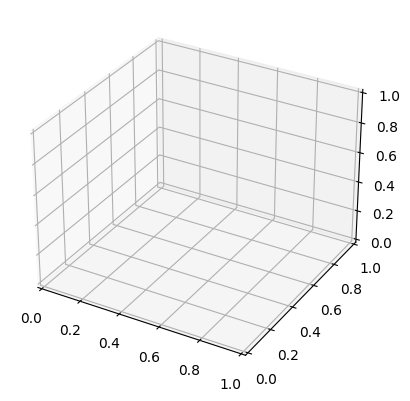

In [510]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Bloch, mesolve, basis, expect, Qobj
from matplotlib import animation

# En supposant que result.states contient les états de la fonction mesolve
states = result.states.copy()

# Fonction pour projeter les états dans le sous-espace des qubits
def project_to_qubit_subspace(state):
    if state.dims[0][0] == 3:
        # En supposant que l'état est dans un espace de Hilbert tridimensionnel
        # Projeter sur les deux premiers niveaux
        data = state.full()[:2, :]
        state = Qobj(data)
    return state

# Projeter tous les états dans le sous-espace des qubits
states = [project_to_qubit_subspace(state) for state in states]

# Réduire le nombre de frames en sélectionnant chaque état n-ième
n = 5  # Ajustez cette valeur pour contrôler le nombre de frames
states = states[::n]

# Créer un objet de la sphère de Bloch
bloch = Bloch()

# Fonction pour mettre à jour la sphère de Bloch pour chaque frame
def update_bloch(num, bloch, states):
    bloch.clear()
    bloch.add_states(states[num])
    bloch.make_sphere()

# Configurer la figure et l'axe
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialiser la sphère de Bloch
bloch.fig = fig
bloch.ax = ax

# Créer l'animation et l'assigner à une variable
# ani = animation.FuncAnimation(fig, update_bloch, fargs=(bloch, states), frames=len(states), repeat=False)

# Sauvegarder l'animation dans un fichier pour s'assurer qu'elle est créée correctement
# ani.save('qubit_evolution.mp4', writer='ffmpeg', fps=30)  # Augmentez fps pour accélérer

# Afficher l'animation
plt.show()

### Impulsion rectangulaire

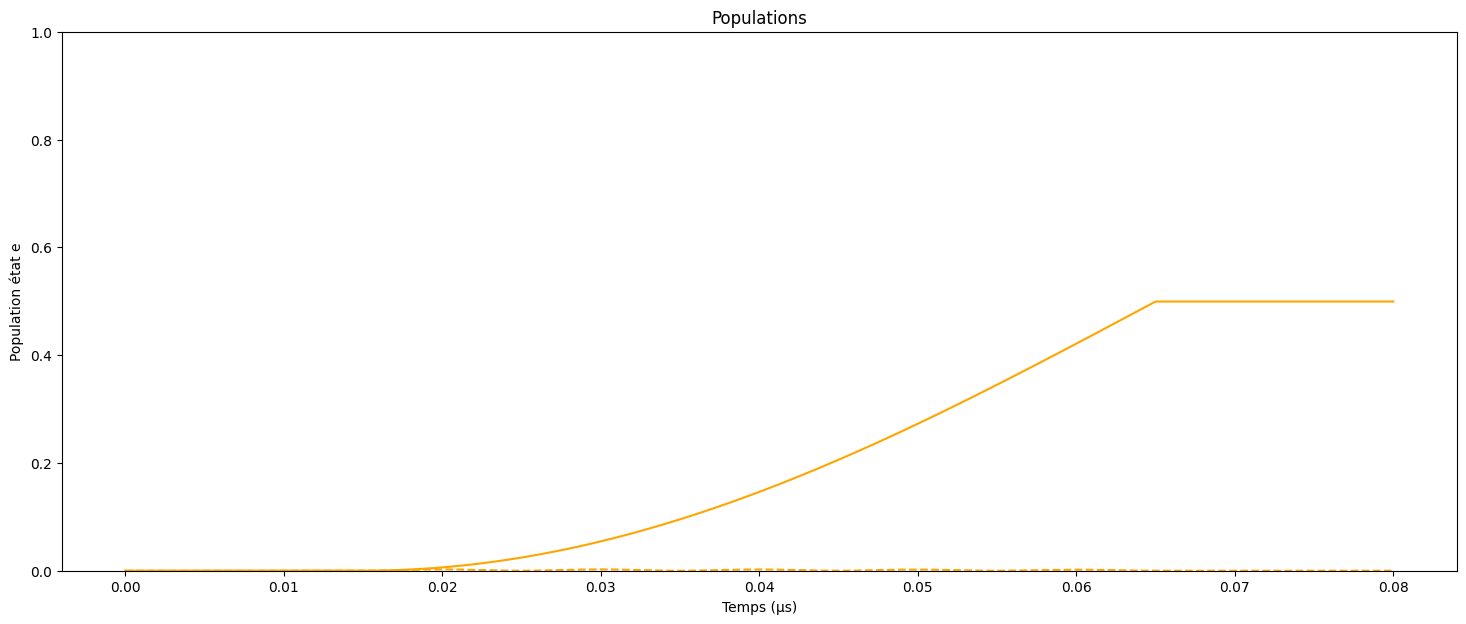

In [511]:
fig = plt.subplots(figsize=(18,7))
plt.title('Populations')
plt.plot(time*1e6,pop_ee_rect,color='orange')
plt.plot(time*1e6,pop_ff_rect,color='orange',ls='--')
plt.ylabel('Population état e')
plt.xlabel('Temps (µs)')
plt.ylim([0,1])
plt.show()

fig = plt.subplots(figsize=(18,7))
plt.title('Champ de pompe')
plt.ylabel('Enveloppe du champ de pompe')
plt.xlabel('Temps (µs)')
plt.plot(time*1e6,rect_enveloppe,'--',color='orange',alpha=1)
plt.show()

Afin de déterminer précisemment la qualité de la porte $\pi/2$, il est possible de calculer la fidélité de l'état obtenu comparé à l'état désiré $|\psi> = 1/\sqrt{2}*(|g> - \textnormal{i} |e>)$:

In [481]:
etat_final = drive_rect[-1] # état final obtenu après l'impulsion pi/2
etat_cible = 1/np.sqrt(2) * (etat3_g - 1j * etat3_e)

print("Fidélité impulsion rectangulaire: \t{:.4%}".format(fidelity(etat_final,etat_cible)))

Fidélité impulsion rectangulaire: 	76.1963%


Routine pour calculer l'évolution de cette fidélité au cours de la préparation:

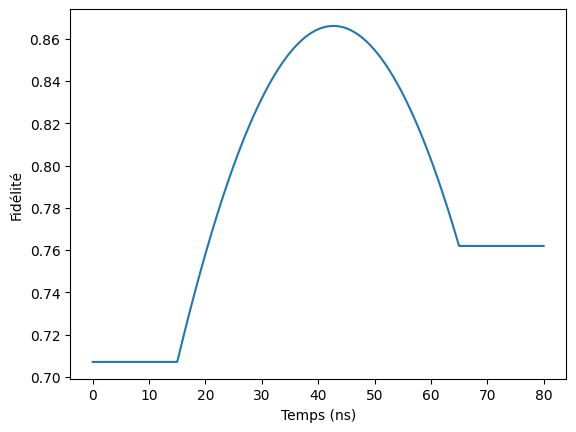

Text(0.5, 0, 'Temps (ns)')

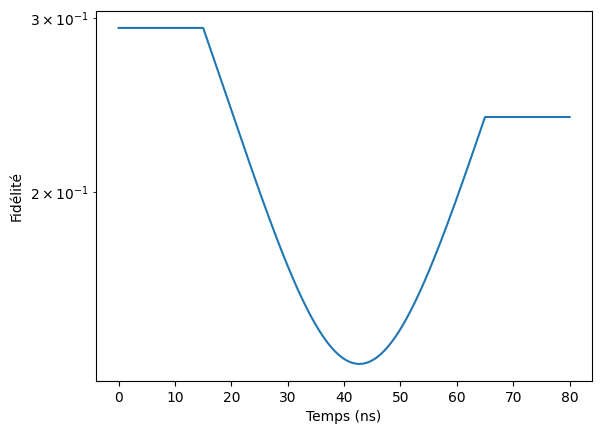

In [482]:
etat_cible = 1/np.sqrt(2)*(etat3_g-1j*etat3_e)
fidelite_rect = [fidelity(etat, etat_cible) for etat in drive_rect]

plt.plot(time*1e9,fidelite_rect)
plt.ylabel('Fidélité')
plt.xlabel('Temps (ns)')
plt.show()

plt.semilogy(time*1e9,1-np.array(fidelite_rect))
plt.ylabel('Fidélité')
plt.xlabel('Temps (ns)')

### impulsion gaussienne

In [483]:
# Impulsion gaussienne:
alpha = 1.24
gaus_width = pulse_width/(2*alpha)
gaus_enveloppe = np.exp(-(time-max_time/2)**2/(2*gaus_width**2))

H_args = {'H0':H0,'H1':H1, 'time_list':time, 'field_list':gaus_enveloppe} # permet de calculer l'évolution du système avec un champ variant dans le temps
result = mesolve(hamiltonian_t, etat3_g, time, [],[], args=H_args, options=Options(max_step=mesolve_max_step))

drive_gaus = result.states
pop_ee_gaus = expect(ee3,drive_gaus)

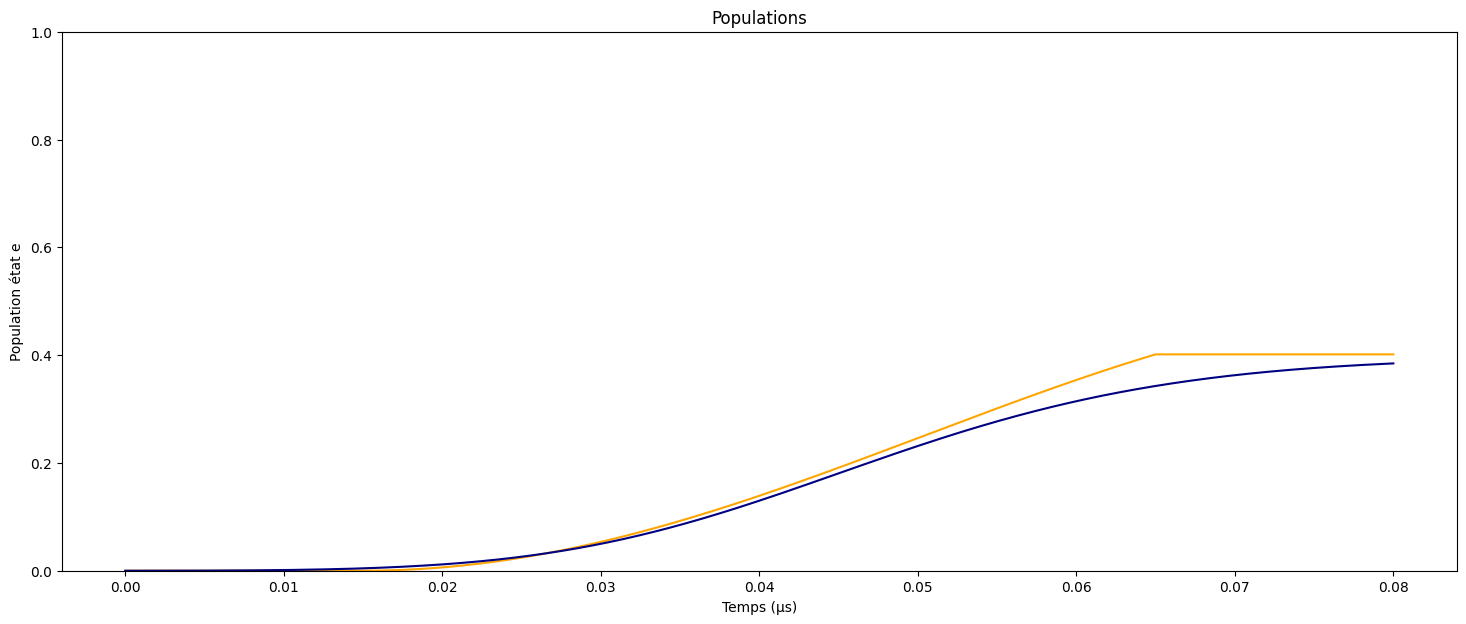

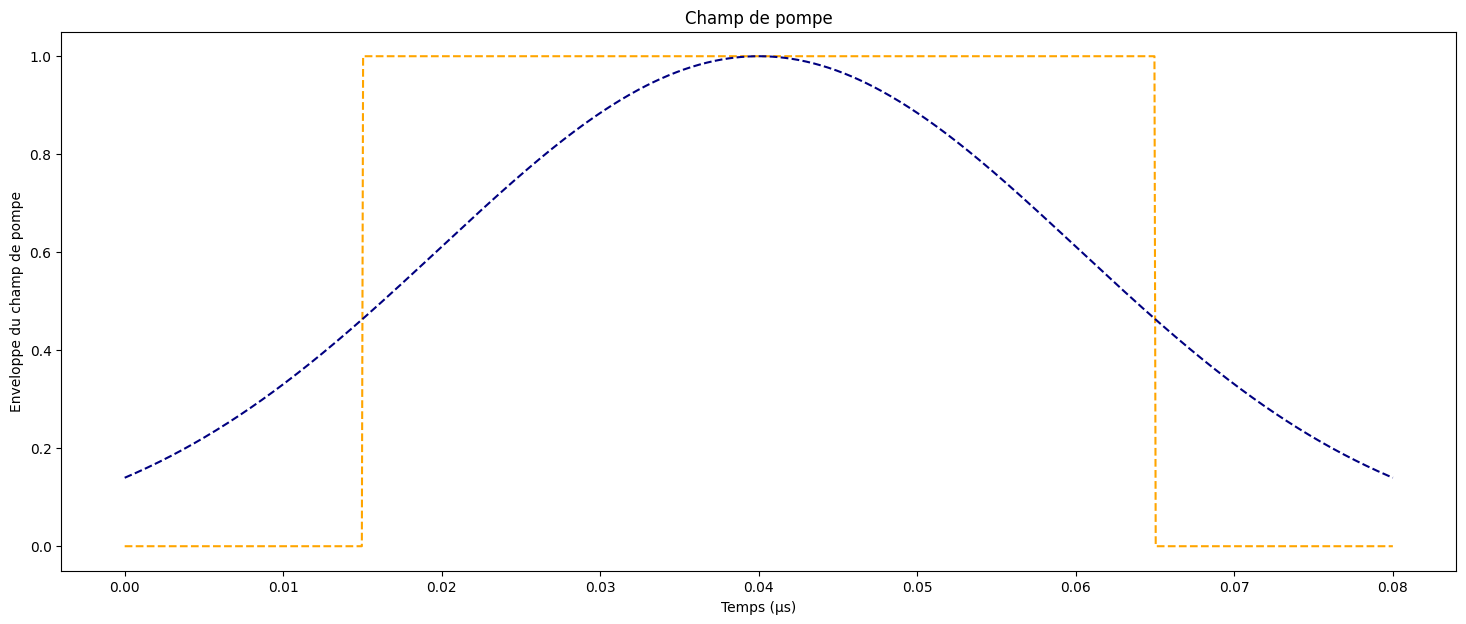

In [484]:
fig = plt.subplots(figsize=(18,7))
plt.title('Populations')
plt.plot(time*1e6,pop_ee_rect,color='orange')
plt.plot(time*1e6,pop_ee_gaus,color = 'navy')
#plt.legend()
plt.ylabel('Population état e')
plt.xlabel('Temps (µs)')
plt.ylim([0,1])
plt.show()

fig = plt.subplots(figsize=(18,7))
plt.title('Champ de pompe')
plt.ylabel('Enveloppe du champ de pompe')
plt.xlabel('Temps (µs)')
plt.plot(time*1e6,rect_enveloppe,'--',color='orange',alpha=1)
plt.plot(time*1e6,gaus_enveloppe,'--',color = 'navy',alpha=1)
#plt.legend()
plt.show()

(0.999, 1.0)

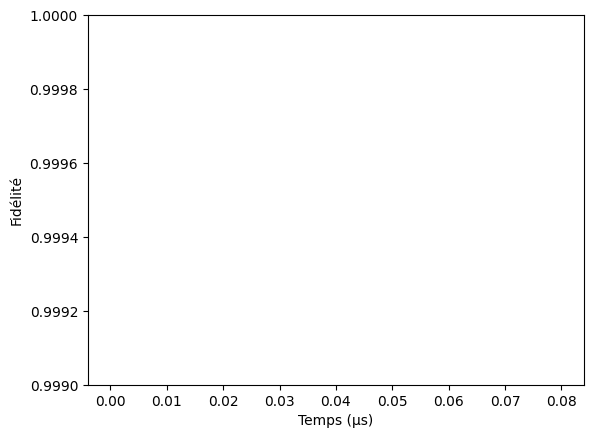

In [485]:
# Impulsion gaussienne:
gaus_width = pulse_width/(2*1.23)
gaus_enveloppe = np.exp(-(time-max_time/2)**2/(2*gaus_width**2))

H_args = {'H0':H0,'H1':H1, 'time_list':time, 'field_list':gaus_enveloppe} # permet de calculer l'évolution du système avec un champ variant dans le temps
result = mesolve(hamiltonian_t, etat3_g, time, [],[], args=H_args, options=Options(max_step=mesolve_max_step))

drive_gaus = result.states


fidelite_gaus = []
for idx_t,_ in enumerate(time):
    tmp = fidelity(drive_gaus[idx_t],1/np.sqrt(2)*(etat3_g-1j*etat3_e))
    fidelite_gaus.append(tmp)

plt.plot(time*1e6,fidelite_gaus)
plt.ylabel('Fidélité')
plt.xlabel('Temps (µs)')
plt.ylim([0.999,1])

In [486]:
etat_final = drive_gaus[-1] # état final obtenu après l'impulsion pi/2
etat_cible = 1/np.sqrt(2) * (etat3_g - 1j * etat3_e)

print("Fidélité impulsion Gaussienne: \t\t{:.4f}%".format(fidelity(etat_final,etat_cible)*100))

etat_final = drive_rect[-1] # état final obtenu après l'impulsion pi/2
etat_cible = 1/np.sqrt(2) * (etat3_g - 1j * etat3_e)

print("Fidélité impulsion rectangulaire: \t{:.4f}%".format(fidelity(etat_final,etat_cible)*100))

Fidélité impulsion Gaussienne: 		77.5677%
Fidélité impulsion rectangulaire: 	76.1963%


In [487]:
pulse_width = 11e-9  # this is a pi/2 pulse in seconds
drive = complex(1/(4*pulse_width),0.0) * 2 * np.pi

H1 = drive/2 * eg3 + np.conjugate(drive)/2 * ge3 + np.sqrt(2)*(drive/2 * fe3 + np.conjugate(drive)/2 * ef3)

rect_enveloppe = np.heaviside(time-max_time/2+pulse_width/2, 1)*np.heaviside(max_time/2-time+pulse_width/2, 1)

H_args = {'H0':H0,'H1':H1, 'time_list':time, 'field_list':rect_enveloppe} # permet de calculer l'évolution du système avec un champ variant dans le temps
result = mesolve(hamiltonian_t, etat3_g, time, [],[], args=H_args, options=Options(max_step=mesolve_max_step))

drive_rect2 = result.states
pop_ee_rect2 = expect(ee3,drive_rect2)
pop_ff_rect2 = expect(ff3,drive_rect2)

### delayed pulses and leakage

In [488]:
pulse_width = 1e-9  # this is a pi/2 pulse in seconds
drive = complex(1/(4*pulse_width),0.0) * 2 * np.pi

H1 = drive/2 * eg3 + np.conjugate(drive)/2 * ge3 + np.sqrt(2)*(drive/2 * fe3 + np.conjugate(drive)/2 * ef3)

gaus_width = pulse_width/(2*alpha)
gaus_enveloppe = np.exp(-(time-max_time/2)**2/(2*gaus_width**2))

H_args = {'H0':H0,'H1':H1, 'time_list':time, 'field_list':gaus_enveloppe} # permet de calculer l'évolution du système avec un champ variant dans le temps
result = mesolve(hamiltonian_t, etat3_g, time, [],[], args=H_args, options=Options(max_step=mesolve_max_step))

drive_gaus2 = result.states
pop_ee_gaus2 = expect(ee3,drive_gaus2)
pop_ff_gaus2 = expect(ff3,drive_gaus2)

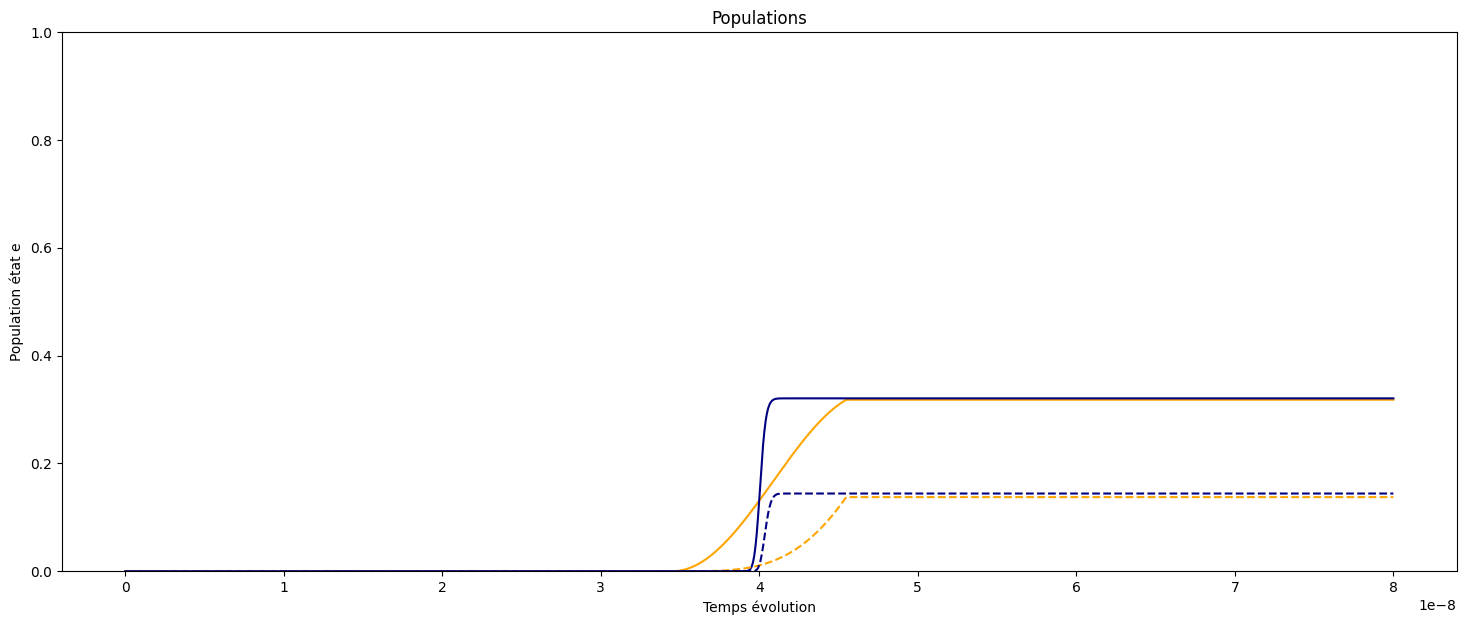

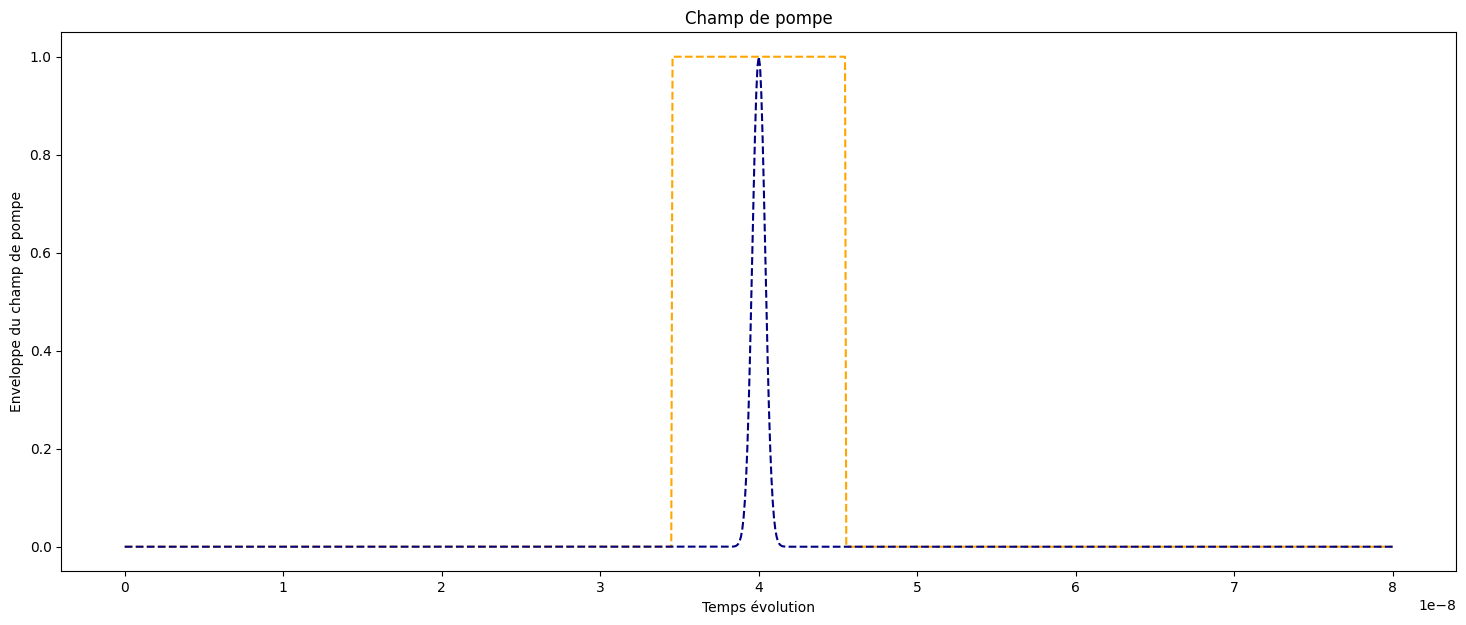

Fidélité impulsion Gaussienne: 		91.7710%
Fidélité impulsion rectangulaire: 	92.0550%


In [489]:
fig = plt.subplots(figsize=(18,7))
plt.title('Populations')
plt.plot(time,pop_ee_rect2,color='orange')
plt.plot(time,pop_ee_gaus2,color = 'navy')
plt.plot(time,pop_ff_rect2,color='orange',ls='--')
plt.plot(time,pop_ff_gaus2,color = 'navy',ls='--')
#plt.legend()
plt.ylabel('Population état e')
plt.xlabel('Temps évolution')
plt.ylim([0,1])
plt.show()

fig = plt.subplots(figsize=(18,7))
plt.title('Champ de pompe')
plt.ylabel('Enveloppe du champ de pompe')
plt.xlabel('Temps évolution')
plt.plot(time,rect_enveloppe,'--',color='orange',alpha=1)
plt.plot(time,gaus_enveloppe,'--',color = 'navy',alpha=1)
#plt.legend()
plt.show()

etat_final = drive_gaus2[-1] # état final obtenu après l'impulsion arbitraire 1
etat_cible = 1/np.sqrt(2) * (etat3_g - 1j * etat3_e)
print("Fidélité impulsion Gaussienne: \t\t{:.4f}%".format(fidelity(etat_final,etat_cible)*100))

etat_final = drive_rect2[-1] # état final obtenu après l'impulsion arbitraire 2
etat_cible = 1/np.sqrt(2) * (etat3_g - 1j * etat3_e)
print("Fidélité impulsion rectangulaire: \t{:.4f}%".format(fidelity(etat_final,etat_cible)*100))

### Profil de fréquence des impulsions


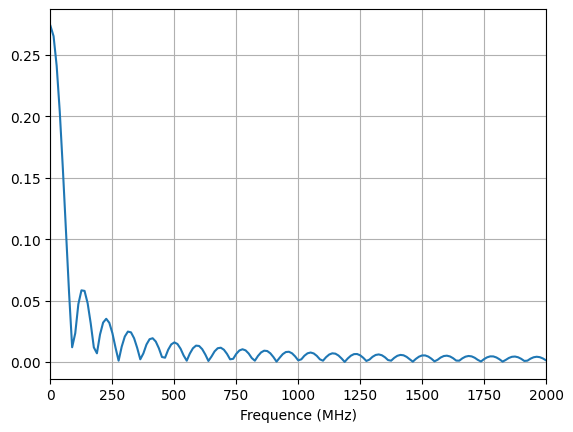

In [490]:
T = (time[1]-time[0])
yf_rec = fft(rect_enveloppe)
xf_rec = fftfreq(len(time), T)


plt.plot(xf_rec[:len(time)//2]*1e-6, 2.0/len(time) * np.abs(yf_rec[0:len(time)//2]))
plt.xlabel('Frequence (MHz)')
plt.grid()
plt.xlim([0,2000])
plt.show()

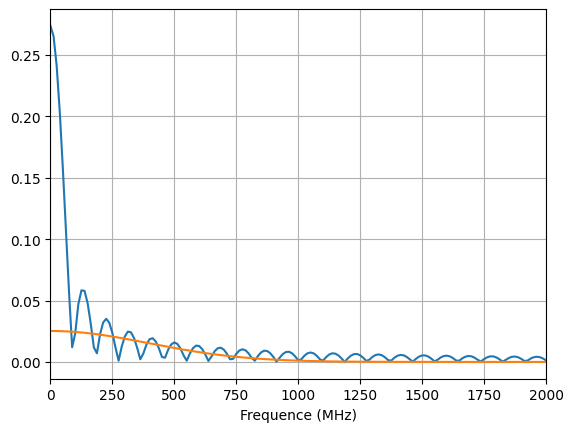

In [491]:
T = (time[1]-time[0])
yf_rec = fft(rect_enveloppe)#rectangular fourier profile
xf_rec = fftfreq(len(time), T)

yf_gaus = fft(gaus_enveloppe)#gaussian fourier profile
xf_gaus = fftfreq(len(time), T)



plt.plot(xf_rec[:len(time)//2]*1e-6, 2.0/len(time) * np.abs(yf_rec[0:len(time)//2]))
plt.plot(xf_gaus[:len(time)//2]*1e-6, 2.0/len(time) * np.abs(yf_gaus[0:len(time)//2]))
plt.xlabel('Frequence (MHz)')
plt.grid()
plt.xlim([0,2000])
plt.show()

### cutting off the frequencies in the rectangular profile and getting a new sharper one

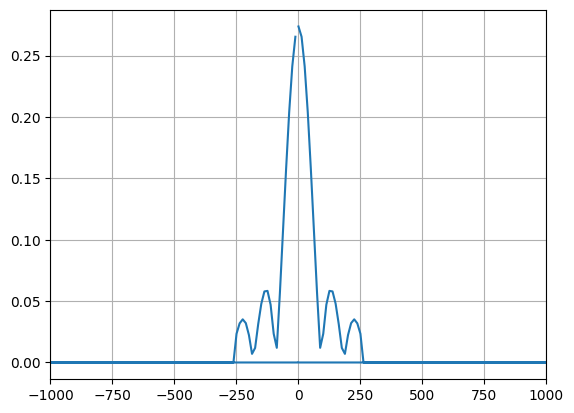

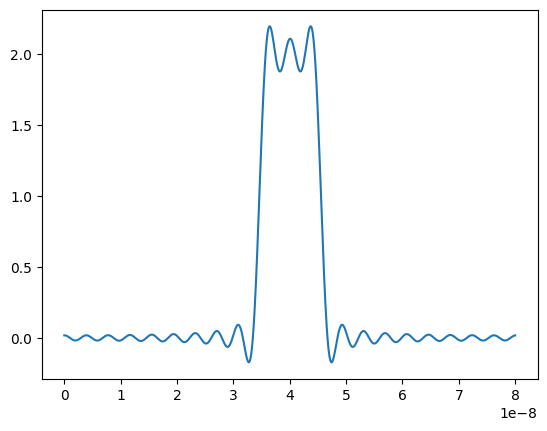

In [492]:
plt.plot(xf_rec*1e-6, 2.0/len(time) * np.abs(yf_rec)*np.heaviside(xf_rec+250e6,1)*np.heaviside(-xf_rec+250e6,1))
plt.vlines(0.05,0,0.0016,alpha=0.5)
plt.xlim([-1000,1000])
plt.grid()
plt.show()

yinv = np.real(fft(2/len(time) *yf_rec*np.heaviside(xf_rec+250e6,1)*np.heaviside(-xf_rec+250e6,1)))
plt.plot(time, yinv)

In [493]:
pulse_width = 11e-9  # this is a pi/2 pulse
drive = complex(1/(4*pulse_width),0.0) * 2 * np.pi

H1 = drive/2 * eg3 + np.conjugate(drive)/2 * ge3 + np.sqrt(2)*(drive/2 * fe3 + np.conjugate(drive)/2 * ef3)

AWG_enveloppe = yinv/np.max(yinv)*1.09

H_args = {'H0':H0,'H1':H1, 'time_list':time, 'field_list':AWG_enveloppe} # permet de calculer l'évolution du système avec un champ variant dans le temps
result = mesolve(hamiltonian_t, etat3_g, time, [],[], args=H_args, options=Options(max_step=mesolve_max_step))

drive_awg = result.states
pop_ee_awg = expect(ee3,drive_awg)

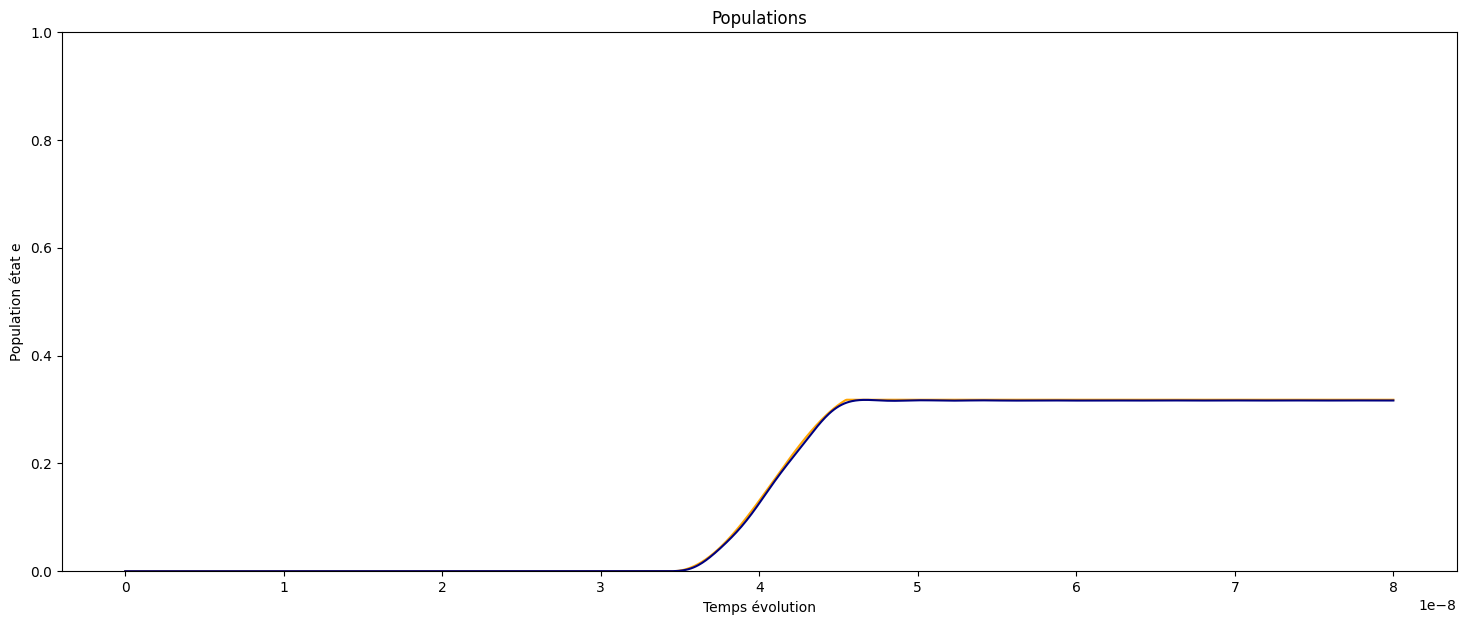

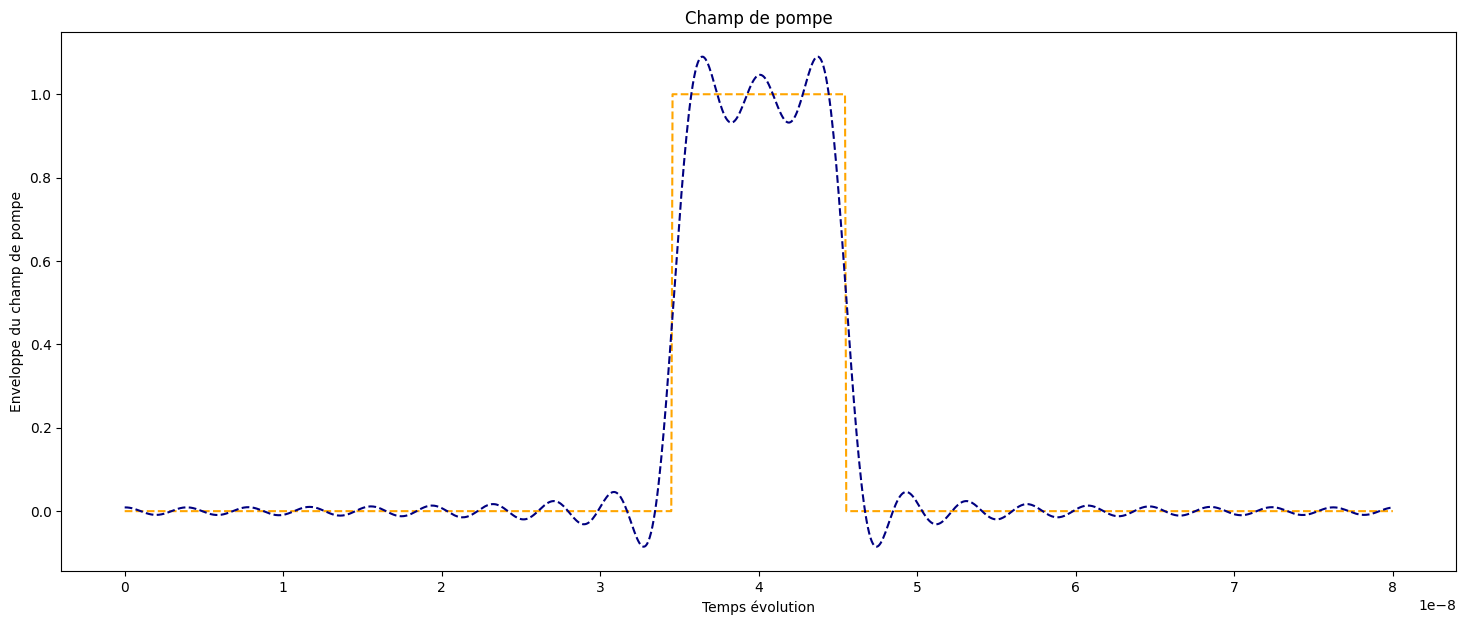

Fidélité impulsion AWG: 		92.1940%
Fidélité impulsion rectangulaire: 	92.0550%


In [494]:
fig = plt.subplots(figsize=(18,7))
plt.title('Populations')
plt.plot(time,pop_ee_rect2,color='orange')
plt.plot(time,pop_ee_awg,color = 'navy')
#plt.legend()
plt.ylabel('Population état e')
plt.xlabel('Temps évolution')
plt.ylim([0,1])
plt.show()

fig = plt.subplots(figsize=(18,7))
plt.title('Champ de pompe')
plt.ylabel('Enveloppe du champ de pompe')
plt.xlabel('Temps évolution')
plt.plot(time,rect_enveloppe,'--',color='orange',alpha=1)
plt.plot(time,AWG_enveloppe,'--',color = 'navy',alpha=1)
#plt.legend()
plt.show()

etat_final = drive_awg[-1] # état final obtenu après l'impulsion pi/2
etat_cible = 1/np.sqrt(2) * (etat3_g - 1j * etat3_e)
print("Fidélité impulsion AWG: \t\t{:.4f}%".format(fidelity(etat_final,etat_cible)*100))

etat_final = drive_rect2[-1] # état final obtenu après l'impulsion pi/2
etat_cible = 1/np.sqrt(2) * (etat3_g - 1j * etat3_e)
print("Fidélité impulsion rectangulaire: \t{:.4f}%".format(fidelity(etat_final,etat_cible)*100))

### Supplement: Comparaison des fidélités:

In [495]:
min_pulse = 1e-9
max_pulse = 30e-9
pulse_list = np.logspace(np.log10(min_pulse),np.log10(max_pulse),11)
fid_gaus = []
fid_rec = []

for pulse_width in pulse_list:  # this is a full 2 pi pulse

    drive = complex(1/(4*pulse_width),0.0) * 2 * np.pi
    H1 = drive/2 * eg3 + np.conjugate(drive)/2 * ge3 + np.sqrt(2)*(drive/2 * fe3 + np.conjugate(drive)/2 * ef3)
    
    # Impulsion rectangulaire:
    rect_enveloppe = np.heaviside(time-max_time/2+pulse_width/2, 1)*np.heaviside(max_time/2-time+pulse_width/2, 1)
    H_args = {'H0':H0,'H1':H1, 'time_list':time, 'field_list':rect_enveloppe} # permet de calculer l'évolution du système avec un champ variant dans le temps

    result = mesolve(hamiltonian_t, etat3_g, time, [],[], args=H_args, options=Options(max_step=mesolve_max_step))
    fid_rec.append(fidelity(result.states[-1],1/np.sqrt(2)*(etat3_g-1j*etat3_e)))

    # Impulsion gaussienne:
    gaus_width = pulse_width/(2*alpha)
    gaus_enveloppe = np.exp(-(time-max_time/2)**2/(2*gaus_width**2))
    H_args = {'H0':H0,'H1':H1, 'time_list':time, 'field_list':gaus_enveloppe} # permet de calculer l'évolution du système avec un champ variant dans le temps

    result = mesolve(hamiltonian_t, etat3_g, time, [],[], args=H_args, options=Options(max_step=mesolve_max_step))
    fid_gaus.append(fidelity(result.states[-1],1/np.sqrt(2)*(etat3_g-1j*etat3_e)))

Text(0.5, 0, 'Impulsion (ns)')

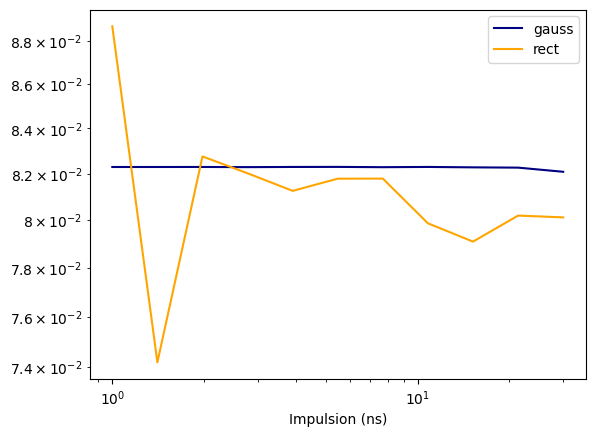

In [496]:
plt.loglog(pulse_list*1e9,1-np.array(fid_gaus),label='gauss',color='navy')
plt.loglog(pulse_list*1e9,1-np.array(fid_rec),label='rect',color='orange')
plt.legend()
plt.xlabel('Impulsion (ns)')